In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Empirical Distribution

## Distribution of a Statistic
* Statistic: a quantity computed for a particular sample
* Distribution: The chance of each outcome of sampling
* Sampling distribution: Chance of each value of a statistic (computed from all possible samples)
    * Also know as **probability distribution of the statistic**
* Empirical distribution: Observations of a statistic (computed from some samples drawn at random)

# Multiple Categories
We have developed a way of assessing models about chance processes that generate data in 2 categories. We can actually extend this method to models involving data in multiple categories. The process of assessment is the same as before, the difference is that **we need to come up with a new statistic to simulate**.

## Jury Selection in Alameda County
In 2010, ACLU (American Civil Liberties Union) of Northern California presented a [report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) regarding jury selection in Alameda County, California. The report concluded that certain ethnic groups are underrepresented among jury panelist in Alameda County, and suggested some reforms of the process by which eligible jurors are assigned to panels. In this section, we'll perform our own analysis of the data and examine some questions that arise as a result.

## Jury Panels
A jury panel is **a group of people chosen to be prospective jurors**. The final trial jury is selected from among them. Jury panels can consist of a few dozen people or several thousand, depending on the trial. By law, a jury panel is supposed to be representative of the community in which the trial is taking place. 

Section 197 of California’s Code of Civil Procedure says, “All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court.”

The final jury is selected from the panel by deliberate inclusion or exclusion. 
* The law allows potential jurors to be excused for medical reasons
* Lawyers on both sides may strike a certain number of potential jurors from the list in "peremptory challenges"
* The trial judge might make a selection based on questionnaires filled out by the panel

However, the initial panel is supposed to resemble a random sample of the population of eligible jurors.

## Composition of Panels in Alameda County
Focus of the study: the ethnic composition of jury panels in Alameda County.
The ACLU compiled data on the ethnic composition of the jury panels in 11 felony trials in Alameda County in the years 2009 and 2010. In those panels, the total number of people who reported for jury service was 1,453. The ACLU gathered demographic data on all of these prospective jurors and compared those data with the composition of all eligible jurors in the county.

The data are compiled in the table `jury` below. 

In [2]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


A bar chart is helpful for visualizing the differences.

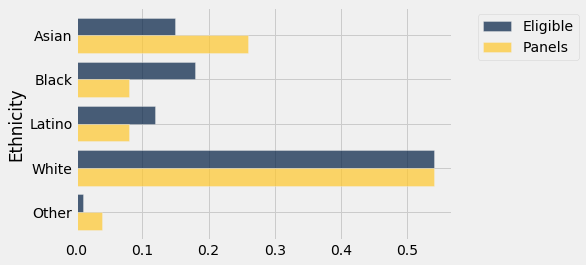

In [3]:
jury.barh('Ethnicity')

### Comparison with Panels Selected at Random
What if we select a random sample of 1,453 people from the population of eligible jurors? Will the distribution of the ethnicities look like the distribution of the panels above?

We can solve this using `sample_proportions` method and augmenting the `jury` table with a column of the proportions in our sample.

**NOTE:** Random sample of prospective jurors are selected **without replacement**. However, when the size of a sample is small relative to the size of the population, sampling without replacement resembles sampling with replacement (the proportions in the population won't change much with each sample draw). The population of eligible jurors in Alameda County is over a million; compared to that, a sample size of 1,500 is small. Thus, we will sample with replacement!

In the cell below, we sample at random 1,453 times from the distribution of eligible jurors and display the distribution of the random sample along with the distributions of the eligible jurors and the panel in the data.

In [4]:
eligible_population = jury.column('Eligible')
sample_distribution = sample_proportions(1453, eligible_population)
panels_and_sample = jury.with_column('Random Sample', sample_distribution)
panels_and_sample

Ethnicity,Eligible,Panels,Random Sample
Asian,0.15,0.26,0.164487
Black,0.18,0.08,0.185822
Latino,0.12,0.08,0.113558
White,0.54,0.54,0.522368
Other,0.01,0.04,0.0137646


The distribution of the random sample is close to the distribution of the eligible population, but not to the distribution of the panels.

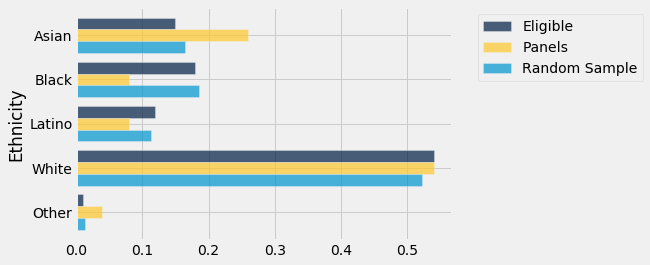

In [6]:
panels_and_sample.barh('Ethnicity')

To assess whether this observation is particular to one random sample or more general, we can simulate multiple panels under the model of random selection and see what the simulations predict. But we won’t be able to look at thousands of bar charts like the one above. We need a statistic that will help us assess whether or not the model or random selection is supported by the data.

## New Statistic: The Distance between 2 Distribution
The differences between 2 numbers `x` and `y` is `| x - y |`. However, in this case we need to quantify the distance between 2 distributions: the blue and gold distribution below.

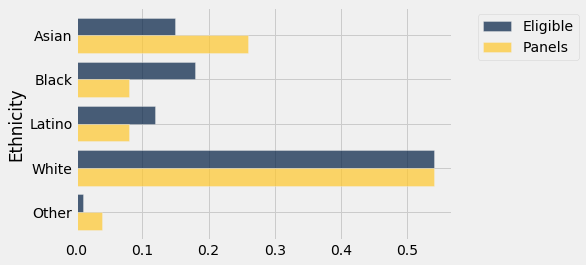

In [7]:
jury.barh('Ethnicity')

For this, we'll compute a quantity called the **total variation distance** between 2 distributions. The calculation is an extension to the calculation of distance between 2 numbers.

We first take the difference between the 2 proportions in each category.

In [8]:
# Augment the table with a column of differences between proportions

jury_with_diffs = jury.with_column(
    'Difference', jury.column('Panels') - jury.column('Eligible')
)
jury_with_diffs

Ethnicity,Eligible,Panels,Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.1
Latino,0.12,0.08,-0.04
White,0.54,0.54,0
Other,0.01,0.04,0.03


Notice that on the **Difference** column, the sum is 0. The positive entries cancel out the negative entries. This is numerical evidence that in the bar chart, the gold bars exceeds the blue bars by exactly as much as the blue bars exceed the gold. The proportions in each of the 2 columns **Panels** and **Eligible** add up to 1, and so the give-and-take between their entries must add up to 0.

To avoid cancellation, we take the absolute values and then sum all the entries; however, this would give us twice the total of the positive entries. Therefore, divide the sum by 2.

In [9]:
jury_with_diffs = jury_with_diffs.with_column(
    'Absolute Difference', np.abs(jury_with_diffs.column('Difference'))
)

jury_with_diffs

Ethnicity,Eligible,Panels,Difference,Absolute Difference
Asian,0.15,0.26,0.11,0.11
Black,0.18,0.08,-0.1,0.1
Latino,0.12,0.08,-0.04,0.04
White,0.54,0.54,0,0
Other,0.01,0.04,0.03,0.03


In [10]:
jury_with_diffs.column('Absolute Difference').sum()/2

0.14

The `0.14` above is the total variation distance (TVD) between the distribution of ethnicities in the eligible juror population and the distribution in the panels.

## Simulating One Value of the Statistic
We can use TVD between distributions as the statistic to simulate. This **helps determining whether the model of random selection is good**, because large values of the distance will be evidence against the model.

Since we're going to compute TVD repeatedly, we'll write a function to compute it.

The function total_variation_distance returns the TVD between distributions in two arrays.

In [11]:
def total_variation_distance(distribution_1, distribution_2):
    return sum(np.abs(distribution_1 - distribution_2)) / 2

`total_variation_distance` helps calculate the statistic in each repetition of the simulation.

In [12]:
total_variation_distance(jury.column('Panels'), jury.column('Eligible'))

0.14